In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import cv2
from PIL import Image


from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import tifffile as tiff

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
images_path = '/content/drive/MyDrive/Water Segmentation/Data/images/'
labels_path = '/content/drive/MyDrive/Water Segmentation/Data/labels/'

In [34]:
x = tiff.imread(images_path+'16.tif')

In [35]:
x.shape

(128, 128, 12)

shape is (H, W, 12)

In [36]:
x.max(), x.min()

(np.int16(4380), np.int16(-15))

In [103]:
mask = Image.open(labels_path + '16.png')
mask = np.array(mask)

In [39]:
mask.max(), mask.min()


(np.uint8(1), np.uint8(0))

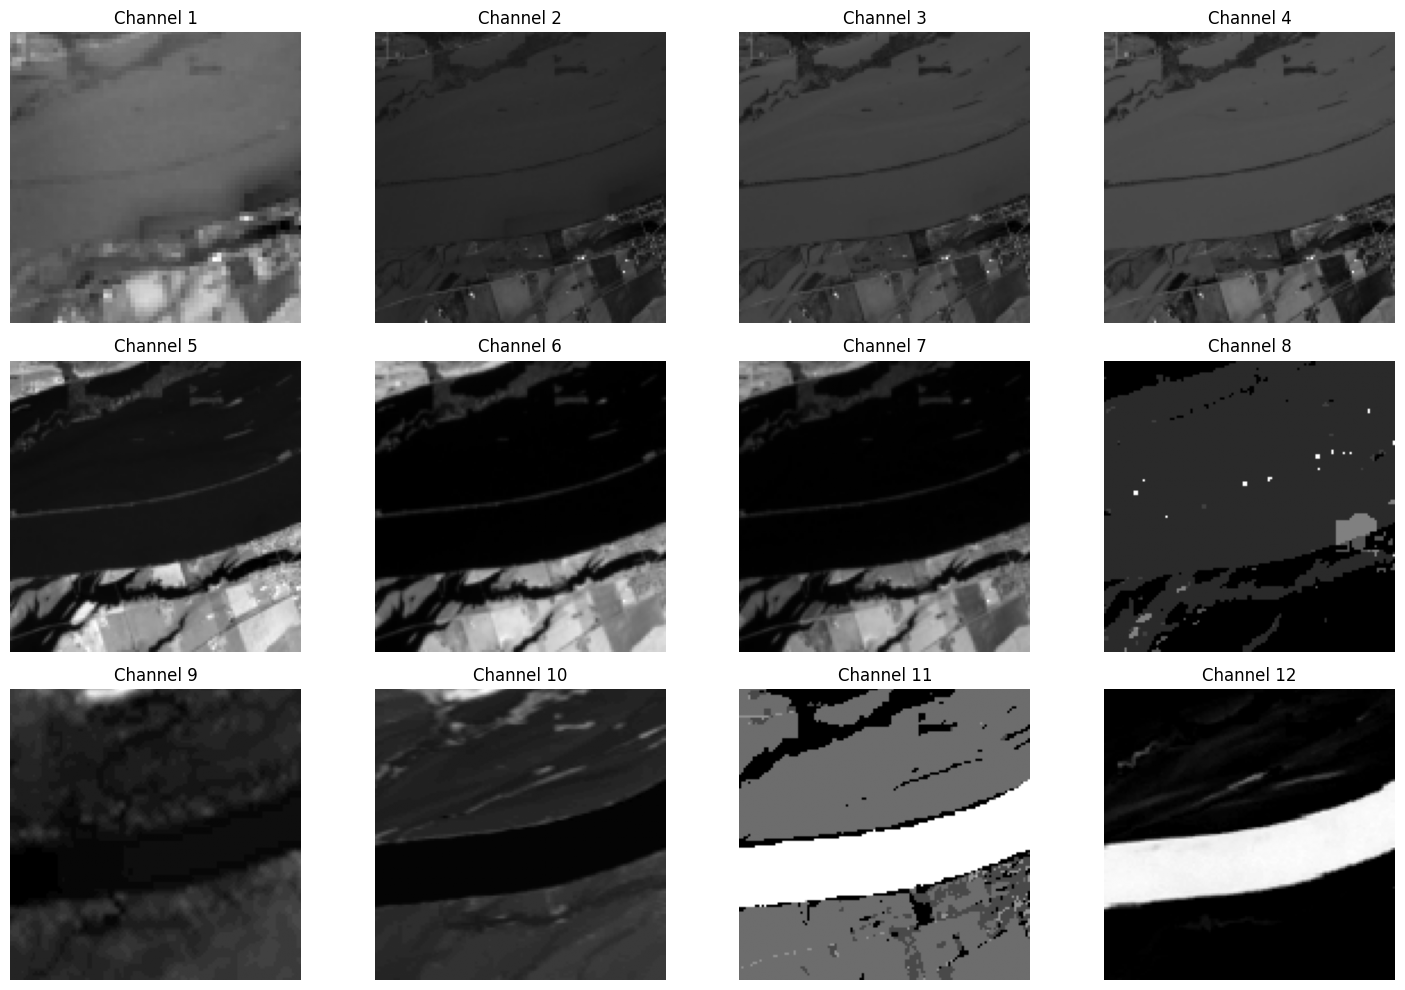

In [40]:
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(x[:, :, i], cmap='gray')
    plt.title(f'Channel {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

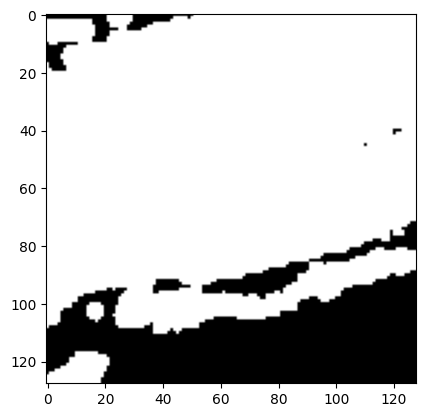

In [104]:
plt.imshow(mask, cmap = 'gray');

In [ ]:
plt.imshow(mask)

In [41]:
folder_path = '/content/drive/MyDrive/Water Segmentation/Data/labels'

for filename in sorted(os.listdir(folder_path)):
    if '_' in filename:
        file_path = os.path.join(folder_path, filename)
        print(f"Deleted: {file_path}")
        os.remove(file_path)

In [42]:
def image_read(img_path, mask_path):
  images = []
  masks = []

  for file_name in sorted(glob.glob(img_path)):

    img = tiff.imread(file_name)

    # Transpose if shape is (12, H, W)
    if img.ndim == 3 and img.shape[0] == 12:
        img = np.transpose(img, (1, 2, 0))

    # Normalize
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)


    images.append(img)

  for file_name in sorted(glob.glob(mask_path)):

    mask = Image.open(file_name)
    mask = np.array(mask)
    masks.append(mask)

  return np.stack(images), np.stack(masks)

In [43]:
images, masks  = image_read(images_path + '*.tif', labels_path + '*.png')

In [44]:
images.shape, masks.shape

((306, 128, 128, 12), (306, 128, 128))

# Visualization

In [45]:
rbg = images[:, :, :, [3,2,1]]

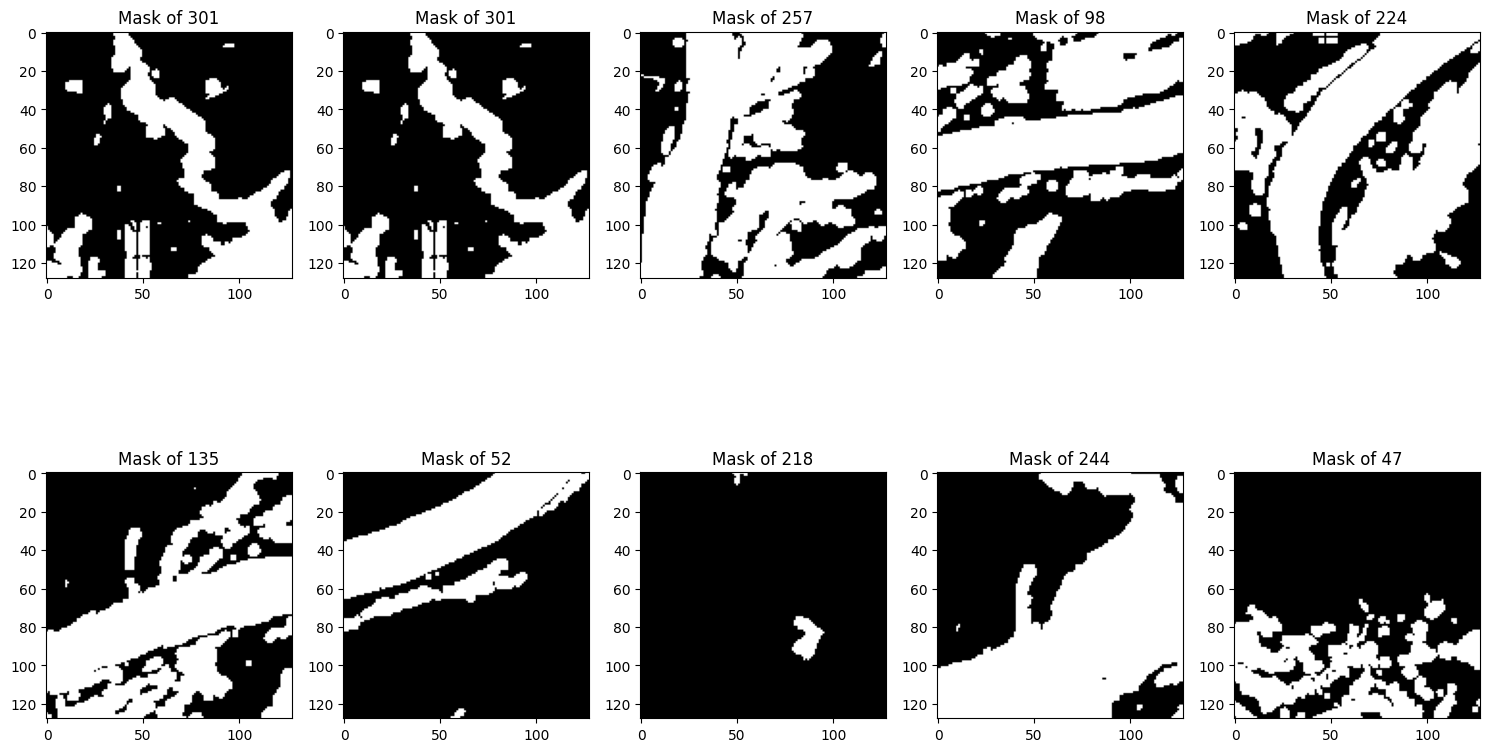

In [46]:
plt.figure(figsize=(15, 10))
for i in range(10):
  x = np.random.randint(0, images.shape[0])
  plt.subplot(2, 5, i+1)
  plt.title(f"Mask of {x}")
  plt.imshow(masks[x], cmap='gray')
plt.tight_layout()
plt.show()

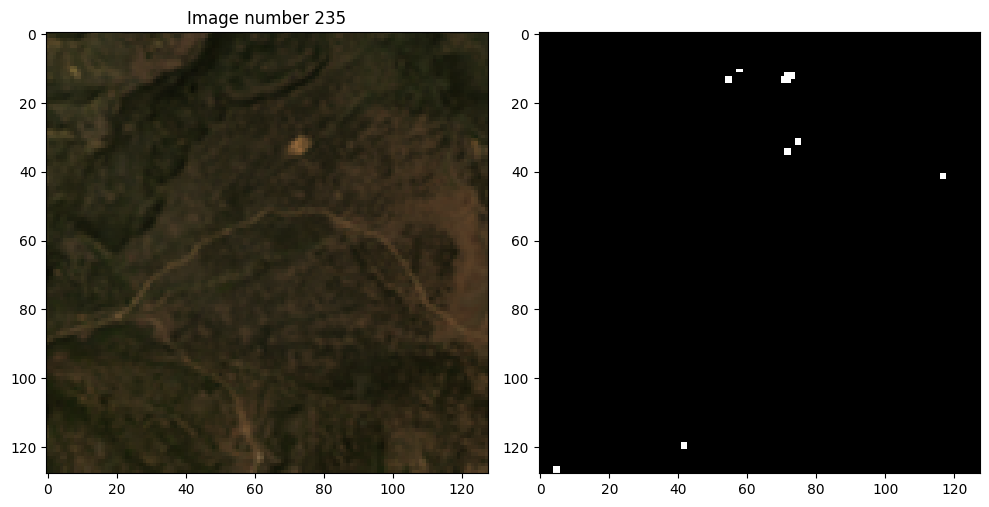

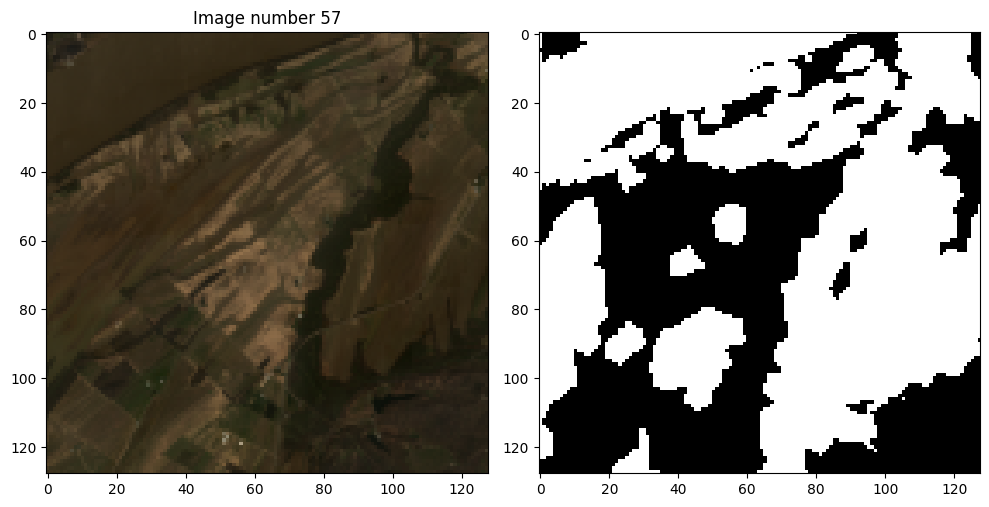

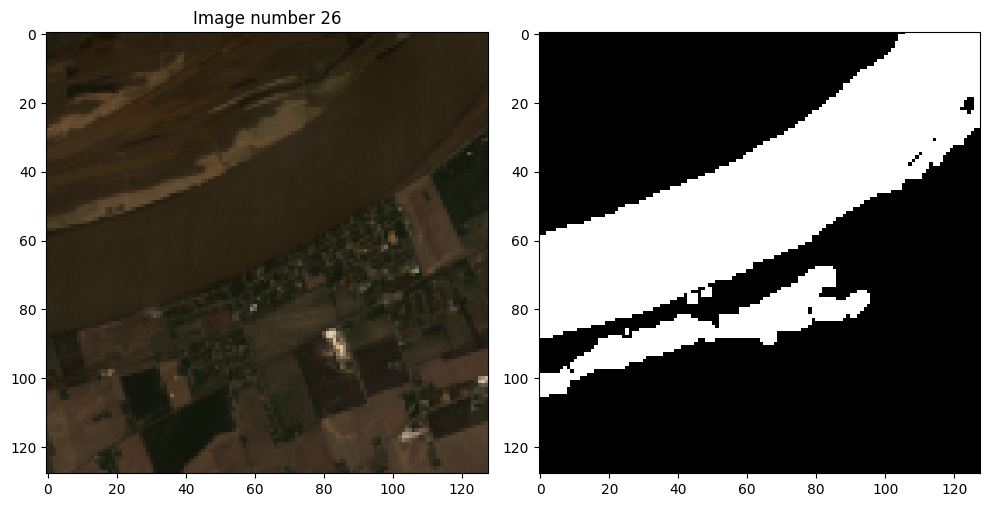

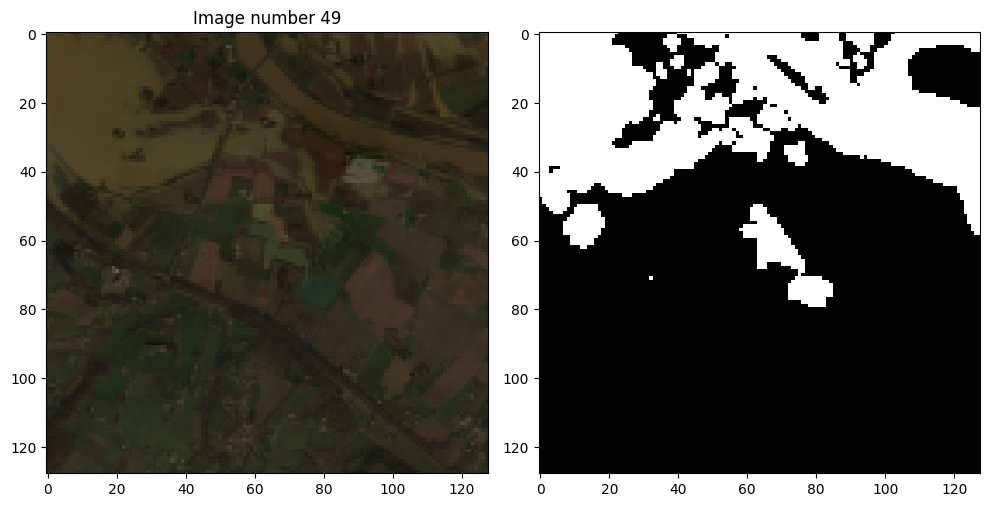

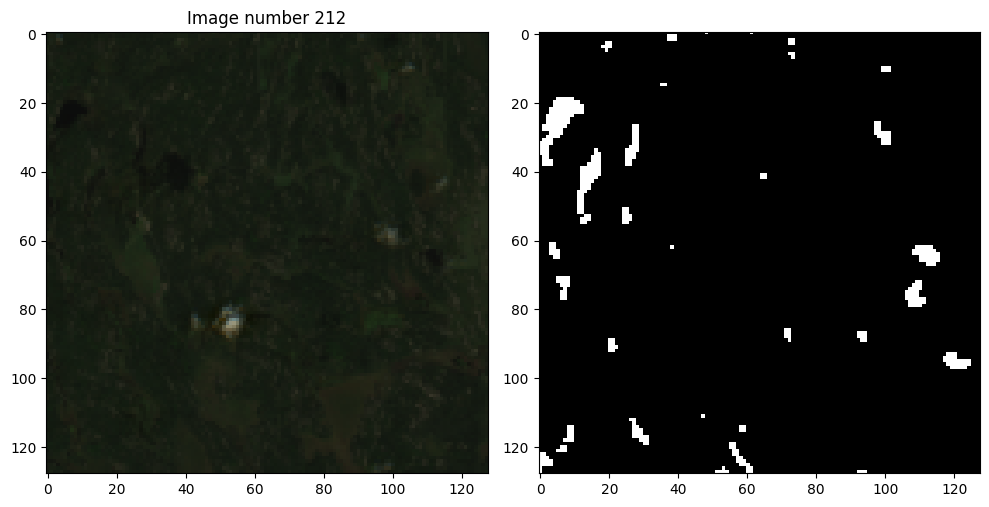

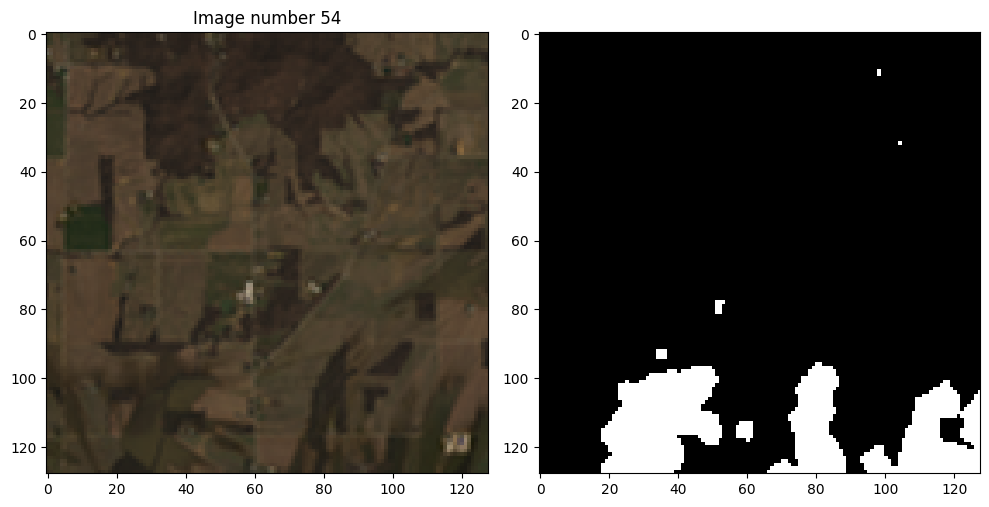

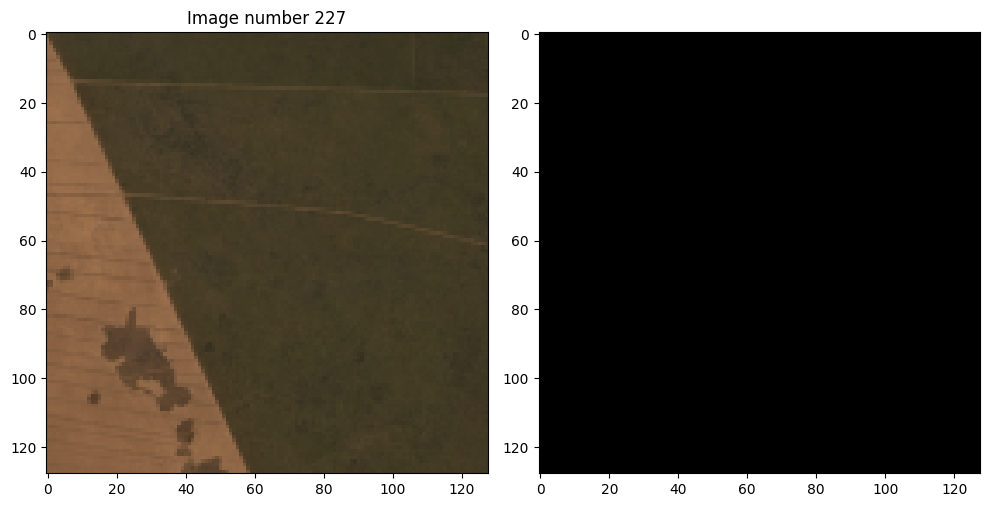

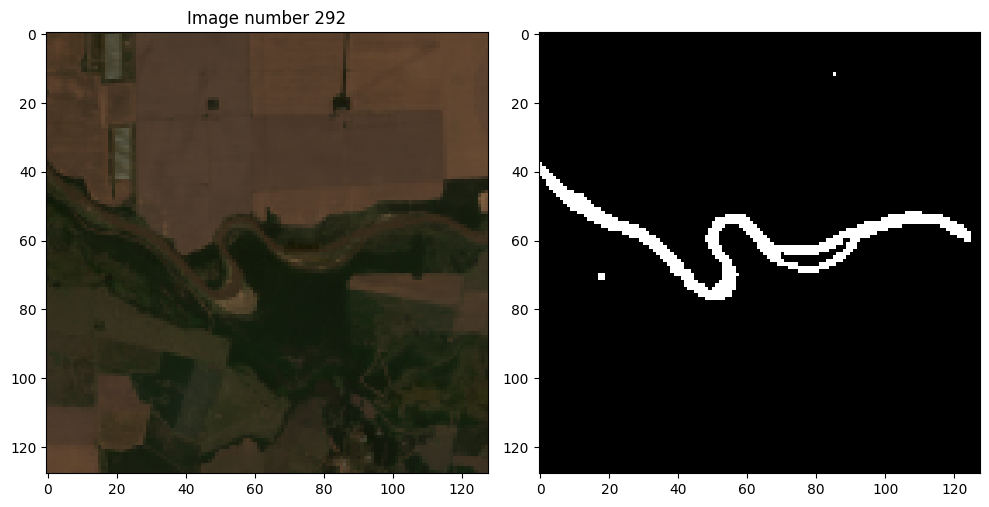

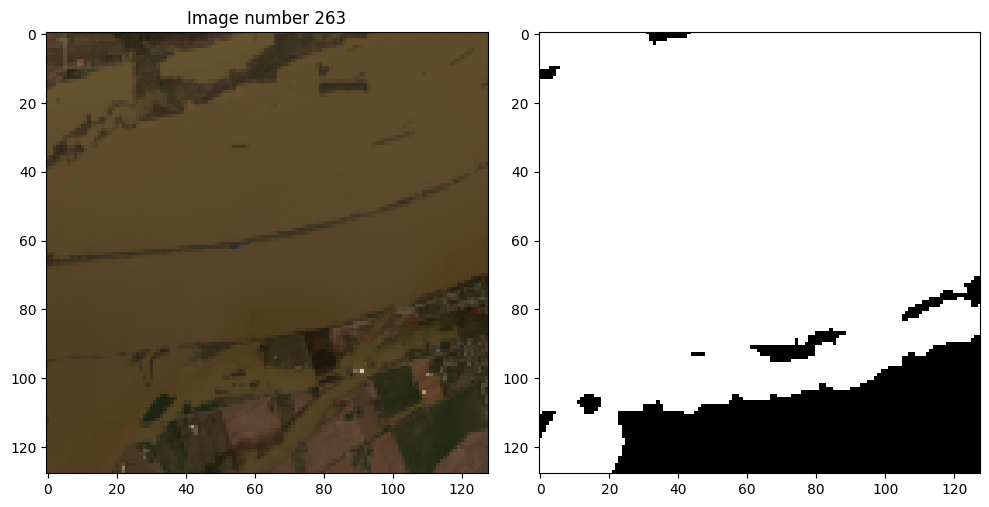

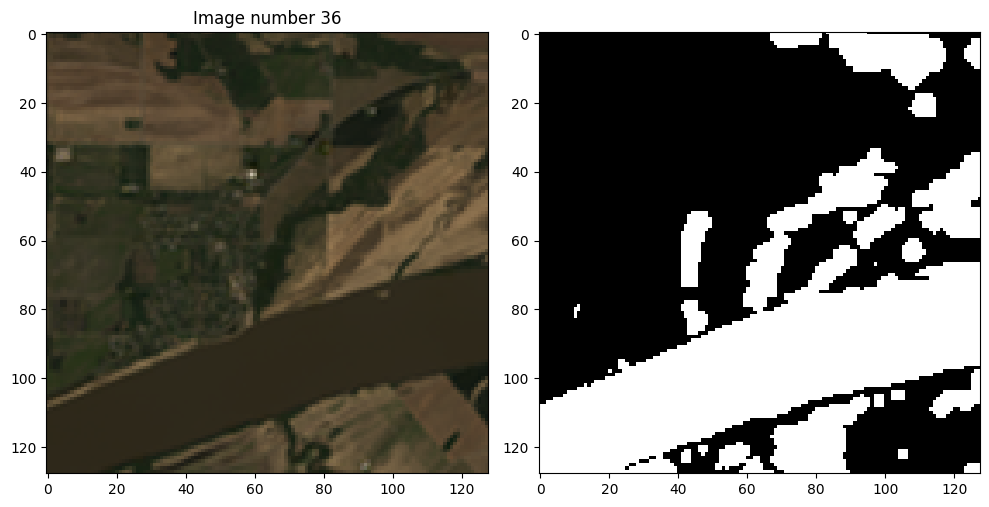

In [47]:
for i in range(10):
  plt.figure(figsize=(10, 8))
  x = np.random.randint(0, images.shape[0])

  plt.subplot(1, 2, 1)
  plt.imshow(rbg[x])

  plt.title(f"Image number {x}")


  plt.subplot(1, 2, 2)
  plt.imshow(masks[x], cmap='gray')

  plt.tight_layout()
  plt.show()

# Preprocessing

In [48]:
image_train, image_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [49]:
image_train.shape, mask_train.shape

((244, 128, 128, 12), (244, 128, 128))

In [50]:
image_test.shape, mask_test.shape

((62, 128, 128, 12), (62, 128, 128))

# Model

In [56]:
def unet_model(input_size):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2),strides=(2,2), padding='same')(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2),strides=(2,2), padding='same')(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2),strides=(2,2), padding='same')(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model


In [67]:
model = unet_model(input_size=(128, 128, 12))

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [68]:
history = model.fit(
    x= image_train,
    y= mask_train,
    steps_per_epoch=len(image_train) // 16,
    epochs=25
)

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 433ms/step - accuracy: 0.8997 - loss: 0.2590
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9126 - loss: 0.2327
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9125 - loss: 0.2325
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.9038 - loss: 0.2418
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9047 - loss: 0.2435
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.9102 - loss: 0.2276
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9135 - loss: 0.2298
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.9114 - loss: 0.2301
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9048 - loss: 0.2476
Epoch 10/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.9071 - loss: 0.2389
Epoch 11/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.8960 - loss: 0.2554
Epoch 12/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/ste

In [69]:
loss, accuracy = model.evaluate(image_test, mask_test)
print(f'Validation Loss: {round(loss, 4)}')
print(f'Validation Accuracy: {round(accuracy * 100, 4)} %')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - accuracy: 0.9186 - loss: 0.2000
Validation Loss: 0.1974
Validation Accuracy: 92.027 %


In [100]:
y_pred = model.predict(image_test)
y_pred = (y_pred > 0.5).astype(np.uint8)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


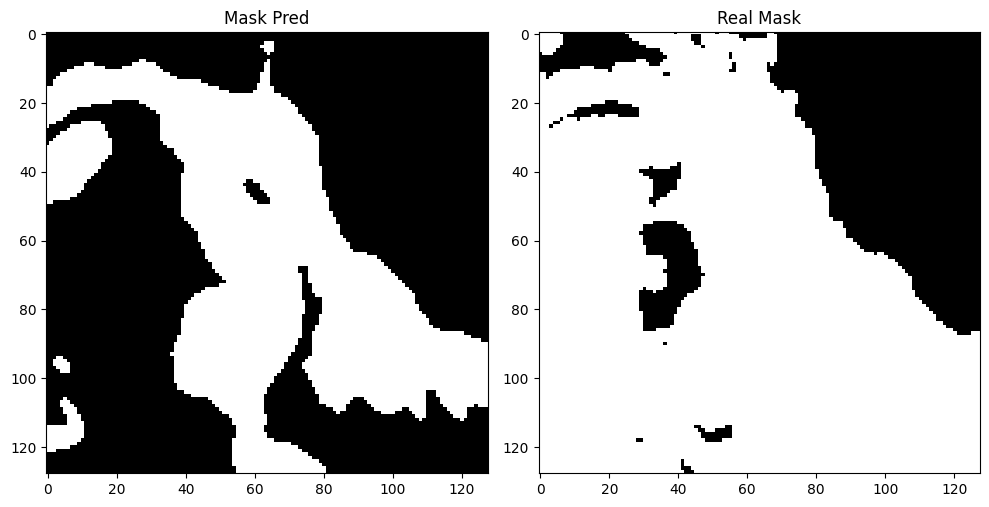

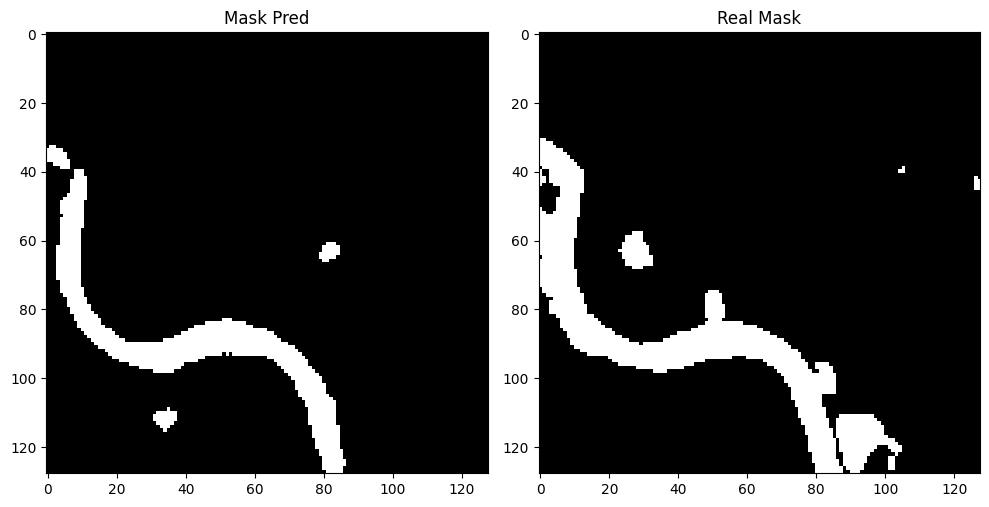

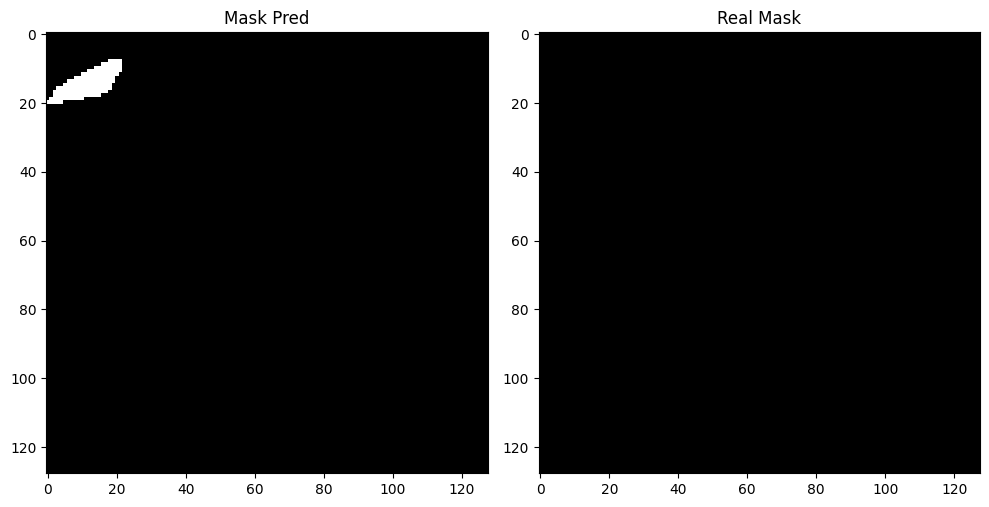

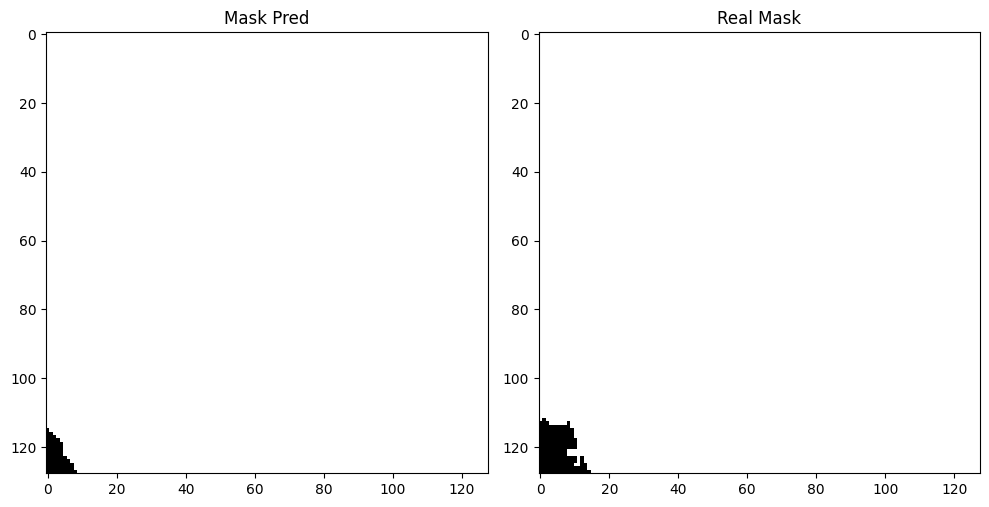

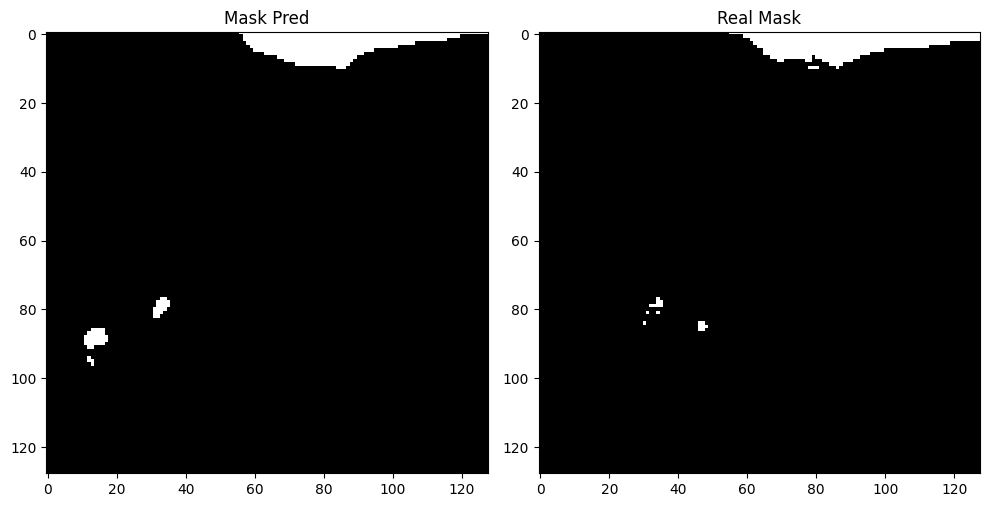

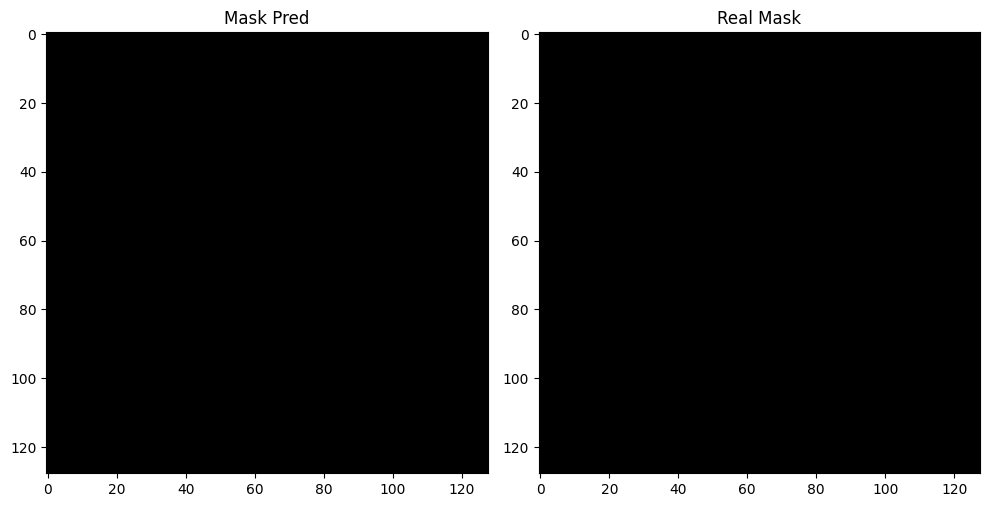

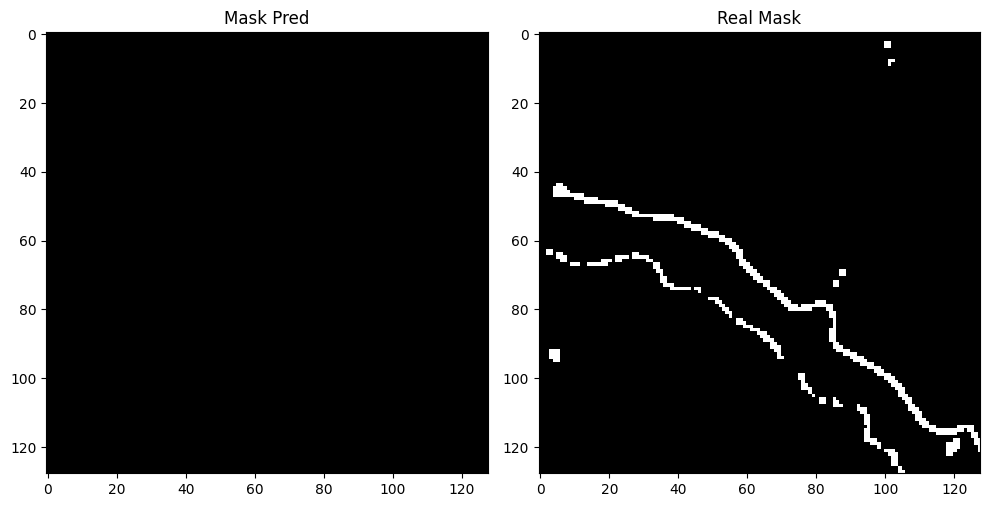

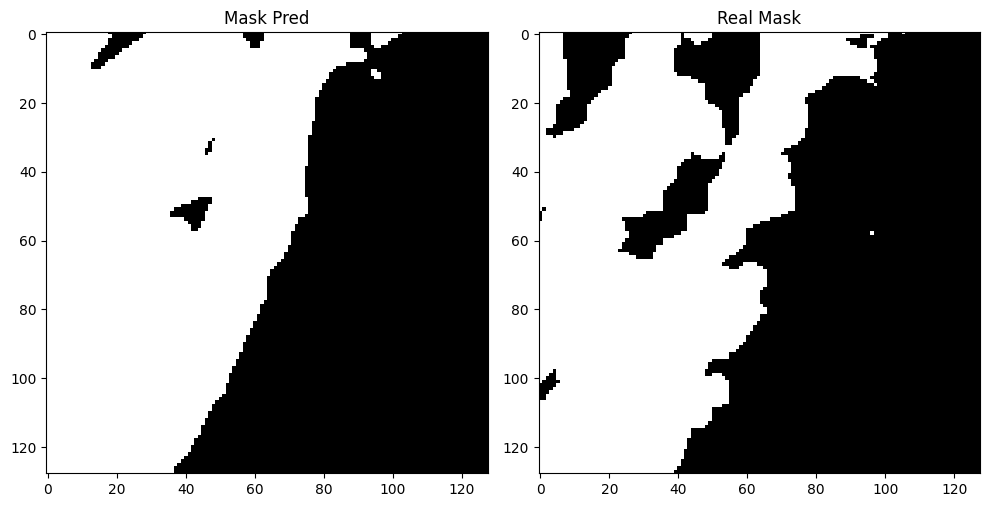

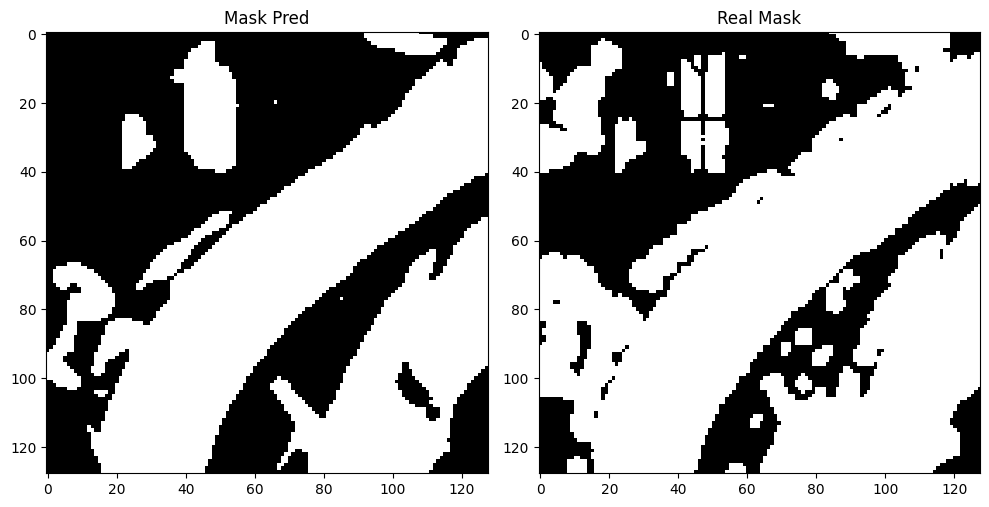

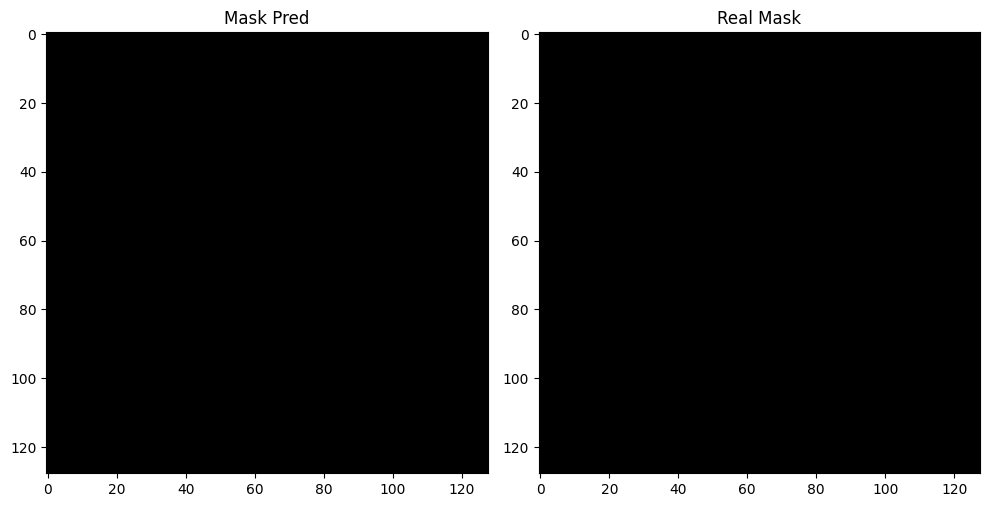

In [101]:
for i in range(10):
  plt.figure(figsize=(10, 8))
  x = np.random.randint(0, image_test.shape[0])

  plt.subplot(1, 2, 1)
  plt.imshow(y_pred[x], cmap='gray')
  plt.title('Mask Pred',)

  plt.subplot(1, 2, 2)
  plt.imshow(mask_test[x], cmap='gray')
  plt.title("Real Mask")

  plt.tight_layout()
  plt.show()